In [1]:
#|default_exp init

# Initialization

In [2]:
pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 22.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb.shape

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [6]:
img = next(iter(dsd['train'][xl]))
img

In [7]:
TF.to_tensor(img).shape

torch.Size([1, 28, 28])

In [8]:
def_device

'cuda'

In [9]:
conv??

Signature: conv(ni, nf, ks=3, stride=2, act=True)
Docstring: <no docstring>
Source:   
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res
File:      /notebooks/miniai/conv.py
Type:      function


In [10]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

In [11]:
y, yhat = tensor((1.,0.,0.)), tensor((.75, .20, .05))

In [12]:
F.cross_entropy(yhat, y)

tensor(0.73)

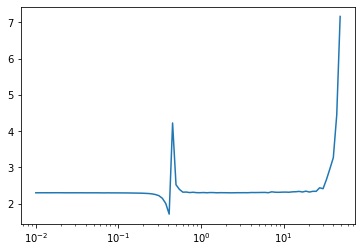

In [13]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [14]:
MetricsCB??

Init signature: MetricsCB(*ms, **metrics)
Docstring:      <no docstring>
Source:        
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
File:           /notebooks/miniai/learner.py
Type:        

In [15]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.296,1.881,0,train
0.679,0.833,0,eval


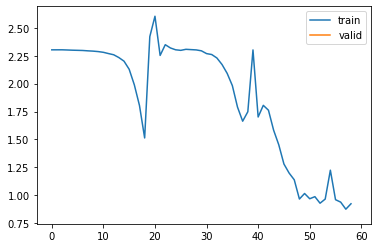

In [16]:
learn.fit(1)

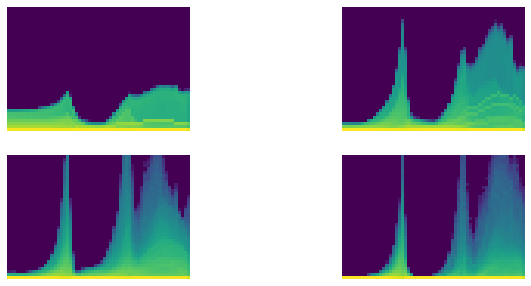

In [17]:
astats.color_dim()

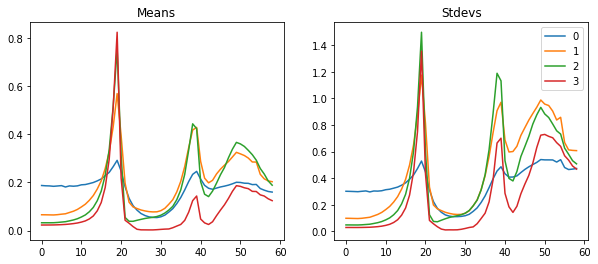

In [18]:
astats.plot_stats()

In [19]:
1+1

2

In [20]:
_

2

In [21]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    # flush memory 
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [22]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [23]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [24]:
clean_mem()

In [25]:
_

''

## Glorot/Xavier init

In [26]:
torch.randn(4,4)

tensor([[-1.36,  0.43,  0.54, -1.15],
        [ 0.83, -1.76,  1.54, -0.52],
        [ 1.07,  0.80,  0.44, -1.17],
        [-0.01,  0.39, -0.16, -0.45]])

In [27]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [28]:
x = torch.randn(200, 100)

In [29]:
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [30]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[ 0.14,  0.15, -0.00,  0.49,  0.13],
        [ 0.28,  0.46,  0.05, -0.62, -0.90],
        [ 0.06,  0.51,  0.16, -0.28, -0.54],
        [ 0.34, -0.57,  0.05,  1.32,  0.75],
        [-0.19,  0.70,  0.31,  1.01, -0.09]])

In [31]:
1 / math.sqrt(100)

0.1

### Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g.:

In [32]:
t = torch.tensor([1.,2.,4.,18])

In [33]:
m = t.mean(); m

tensor(6.25)

In [34]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [35]:
(t-m).pow(2).mean()

tensor(47.19)

In [36]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [37]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [38]:
(t**2).mean() - (t.mean()**2)

tensor(47.19)

In [39]:
(t-t.mean()).pow(2).mean()

tensor(47.19)

In [40]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

Let's see that in code. So now we need two vectors.

In [41]:
t

tensor([ 1.,  2.,  4., 18.])

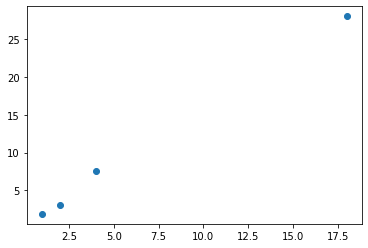

In [42]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [43]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 43.28,  29.82,   5.89, 210.09])

In [44]:
prod.mean()

tensor(72.27)

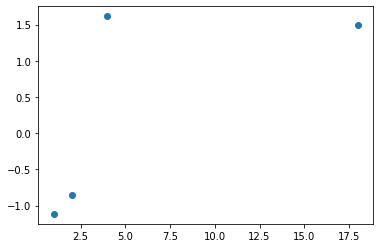

In [45]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [46]:
((t-t.mean())*(v-v.mean())).mean()

tensor(5.86)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [47]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(5.86)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [48]:
cov / (t.std() * v.std())

tensor(0.50)

It's just a scaled version of the same thing.

In [49]:
x.std()

tensor(0.80)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [50]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.07), tensor(0.99))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [51]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(-0.016362724490463734, 99.8384506225586)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [52]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(-0.002965190123281627, 0.9689520599500063)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

### Background

In [53]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [54]:
from math import sqrt

In [55]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [56]:
def lin(x, w, b): return x @ w + b

In [57]:
# foward pass simple liner nn
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(-0.00), tensor(0.99))

In [58]:
def relu(x): return x.clamp_min(0.)

In [59]:
l2 = relu(l1)
l2.mean(),l2.std() # zero mean is gone after relu, relu will squeeze the negatives

(tensor(0.39), tensor(0.58))

In [60]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [61]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5] # we get non zeros after 50 layer deep 

tensor([[1.29, 0.25, 0.11, 1.76, 0.00],
        [0.74, 0.11, 0.11, 1.08, 0.00],
        [0.70, 0.14, 0.09, 0.98, 0.00],
        [0.61, 0.12, 0.13, 0.90, 0.00],
        [1.06, 0.10, 0.07, 1.56, 0.00]])

### Applying an init function

In [62]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [63]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

In [64]:
params = model.parameters()

In [65]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [66]:
for i,p in enumerate(model.parameters()): print(p.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([10, 64, 3, 3])
torch.Size([10])


In [67]:
model.apply(init_weights);

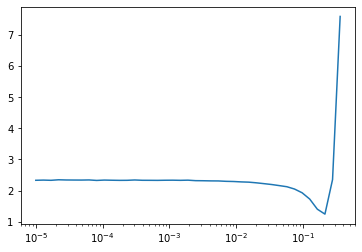

In [68]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [69]:
10 ** -1

0.1

In [70]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.586,1.232,0,train
0.777,0.616,0,eval
0.819,0.489,1,train
0.830,0.466,1,eval
0.843,0.426,2,train
0.846,0.422,2,eval


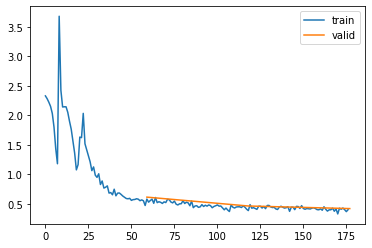

In [71]:
learn.fit(3)

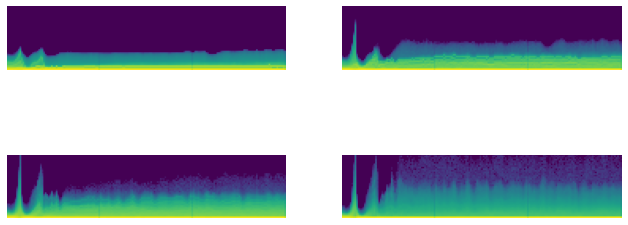

In [72]:
astats.color_dim()

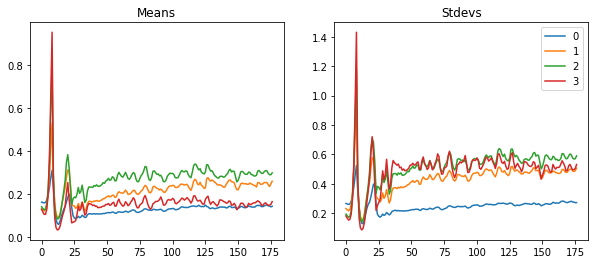

In [73]:
astats.plot_stats()

## Input normalization

In [74]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In [75]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [76]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.549,1.391,0,train
0.752,0.652,0,eval
0.808,0.518,1,train
0.819,0.486,1,eval
0.843,0.429,2,train
0.838,0.441,2,eval


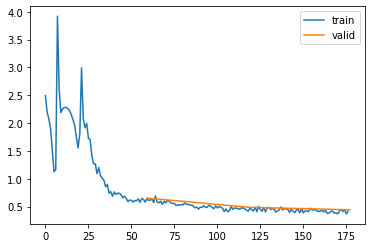

In [77]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

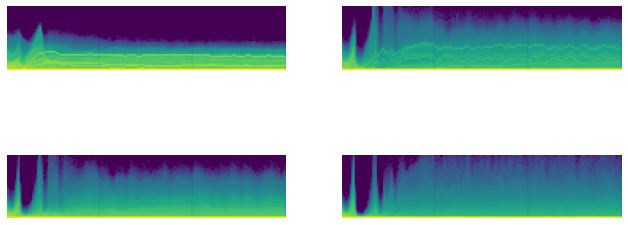

In [78]:
astats.color_dim()

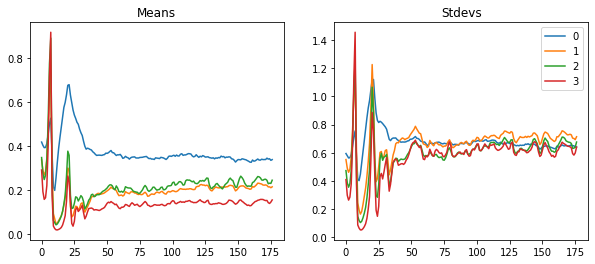

In [79]:
astats.plot_stats()

In [80]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [81]:
xl

'image'

In [82]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [83]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [84]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU



In [85]:
F.leaky_relu??

Signature:
F.leaky_relu(
    input: torch.Tensor,
    negative_slope: float = 0.01,
    inplace: bool = False,
) -> torch.Tensor
Source:   
def leaky_relu(input: Tensor, negative_slope: float = 0.01, inplace: bool = False) -> Tensor:
    r"""
    leaky_relu(input, negative_slope=0.01, inplace=False) -> Tensor

    Applies element-wise,
    :math:`\text{LeakyReLU}(x) = \max(0, x) + \text{negative\_slope} * \min(0, x)`

    See :class:`~torch.nn.LeakyReLU` for more details.
    """
    if has_torch_function_unary(input):
        return handle_torch_function(leaky_relu, (input,), input, negative_slope=negative_slope, inplace=inplace)
    if inplace:
        result = torch._C._nn.leaky_relu_(input, negative_slope)
    else:
        result = torch._C._nn.leaky_relu(input, negative_slope)
    return result
File:      /usr/local/lib/python3.9/dist-packages/torch/nn/functional.py
Type:      function


In [86]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [87]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

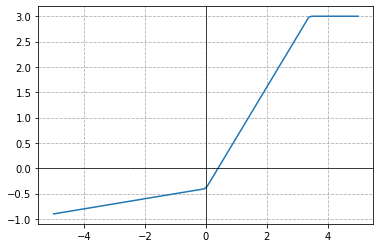

In [145]:
plot_func(GeneralRelu(leak=0.1, sub=.4, maxv=3))

In [89]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [90]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64] # change num filters
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [91]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [92]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [93]:
model = get_model(act_gr).apply(iw)

In [94]:
xb_, yb_ = next(iter(dls.train))

In [95]:
xb_.mean(), xb.std()

(tensor(-0.02), tensor(1.00))

accuracy,loss,epoch,train
0.774,0.625,0,train
0.846,0.421,0,eval
0.868,0.361,1,train
0.861,0.373,1,eval
0.880,0.325,2,train
0.866,0.365,2,eval


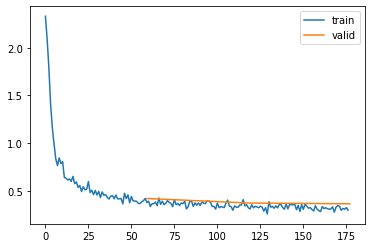

In [96]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

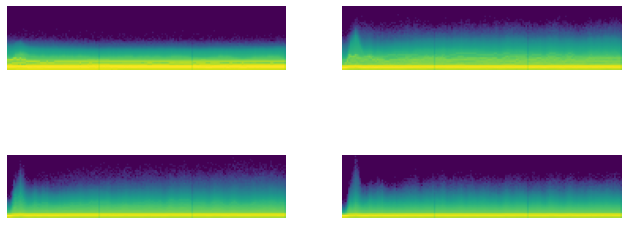

In [97]:
astats.color_dim()

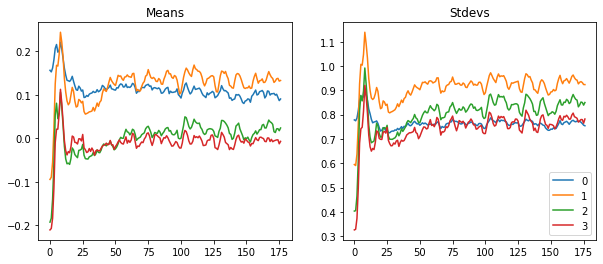

In [98]:
astats.plot_stats()

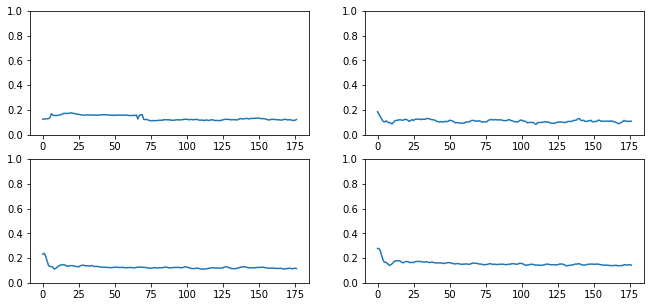

In [99]:
astats.dead_chart()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

In [100]:
Hook??

Init signature: Hook(m, f)
Docstring:      <no docstring>
Source:        
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
File:           /notebooks/miniai/activations.py
Type:           type
Subclasses:     


In [101]:
#| export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    # import pdb; pdb.set_trace()
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    print(m, m_in)
    # import pdb; pdb.set_trace()
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            print("before", h.mean, h.std)
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
        print("after", h.mean, h.std)
    h.remove()

In [102]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [103]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [104]:
m, m_in = next(zip(relus, convs))
xb_ = xb.to(def_device)
h = Hook(m, _lsuv_stats)

In [105]:
model(xb_)

tensor([[-0.22, -0.10, -0.11,  ...,  0.16, -0.05, -0.21],
        [-0.22, -0.10, -0.11,  ...,  0.16, -0.06, -0.22],
        [-0.22, -0.10, -0.11,  ...,  0.16, -0.05, -0.21],
        ...,
        [-0.22, -0.10, -0.11,  ...,  0.15, -0.05, -0.21],
        [-0.22, -0.11, -0.11,  ...,  0.16, -0.05, -0.22],
        [-0.22, -0.11, -0.12,  ...,  0.16, -0.05, -0.21]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [110]:
# now the hook hs populated
h.mean

tensor(-0.10)

In [107]:
h??

Type:        Hook
String form: <__main__.Hook object at 0x7feb09529a90>
Docstring:   <no docstring>


In [108]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))

GeneralRelu() Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
before tensor(-0.22) tensor(0.35)
before tensor(0.18) tensor(0.93)
before tensor(0.11) tensor(0.94)
before tensor(0.08) tensor(0.96)
before tensor(0.06) tensor(0.97)
before tensor(0.05) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
after tensor(0.00) tensor(1.00)
GeneralRelu() Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
before tensor(-0.24) tensor(0.38)
before tensor(0.16) tensor(1.05)
before tensor(0.04) tensor(0.96)
before tensor(0.04) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.0

accuracy,loss,epoch,train
0.772,0.650,0,train
0.833,0.454,0,eval
0.863,0.377,1,train
0.852,0.400,1,eval
0.876,0.337,2,train
0.860,0.379,2,eval


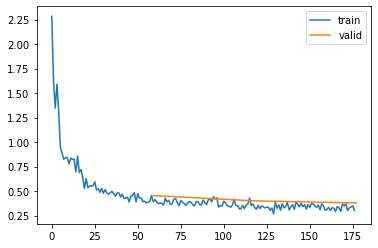

In [109]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

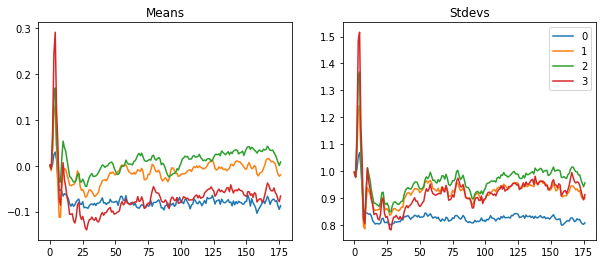

In [219]:
astats.plot_stats()


## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

In [128]:
t = torch.randn((64, 3, 28,28))
m = t.mean((1,2,3),keepdim=True)
m.shape

torch.Size([64, 1, 1, 1])

In [129]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # NCHW->mean over CHW final shape N,1,1,1
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt()) # normalising and avoiding zero div with epsilon
        return x*self.mult + self.add

In [130]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [131]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.781,0.606,0,train
0.845,0.421,0,eval
0.865,0.370,1,train
0.859,0.377,1,eval
0.882,0.321,2,train
0.867,0.360,2,eval


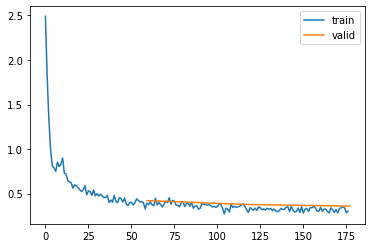

In [124]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [132]:
t = torch.randn((64, 3, 28,28))
m = t.mean((0,2,3),keepdim=True)
m.shape

torch.Size([1, 3, 1, 1])

In [139]:
torch.lerp(tensor(5.), tensor(15.), tensor(.1))

tensor(6.)

In [133]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom) # replace in place means based on momentum
        self.vars.lerp_ (v, self.mom) # 
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.799,0.548,0,train
0.812,0.604,0,eval
0.873,0.343,1,train
0.868,0.370,1,eval
0.886,0.306,2,train
0.871,0.361,2,eval


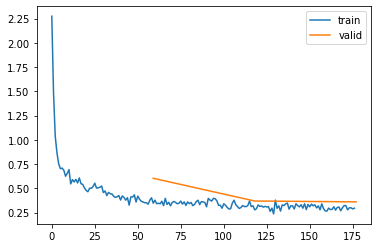

In [134]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90%...

In [143]:
get_model??

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      /tmp/ipykernel_97/111808998.py
Type:      function


In [140]:
DataLoaders.from_dd??

Signature: DataLoaders.from_dd(dd, batch_size, as_tuple=True, **kwargs)
Docstring: <no docstring>
Source:   
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
File:      /notebooks/miniai/datasets.py
Type:      method


In [141]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.837,0.450,0,train
0.866,0.366,0,eval
0.882,0.318,1,train
0.872,0.354,1,eval
0.897,0.279,2,train
0.881,0.325,2,eval


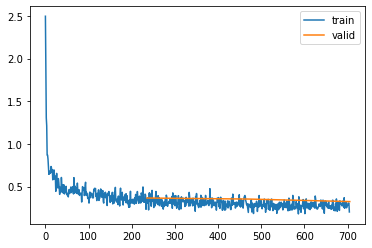

In [142]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.918,0.224,0,train
0.896,0.285,0,eval
0.922,0.211,1,train
0.902,0.277,1,eval


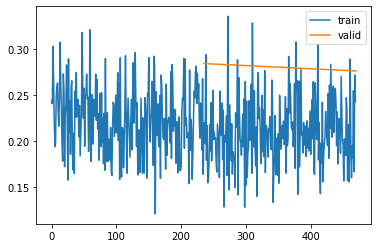

In [144]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()